In [1]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import plotly
from scipy import stats
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")

data = pd.read_csv('car_prices.csv', on_bad_lines='skip')

#Get rid of the irrelevent columns
data = data.drop(['vin'], axis=1)



data.head(50)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)
5,2015,Nissan,Altima,2.5 S,Sedan,automatic,ca,1.0,5554.0,gray,black,enterprise vehicle exchange / tra / rental / t...,15350,10900,Tue Dec 30 2014 12:00:00 GMT-0800 (PST)
6,2014,BMW,M5,Base,Sedan,automatic,ca,3.4,14943.0,black,black,the hertz corporation,69000,65000,Wed Dec 17 2014 12:30:00 GMT-0800 (PST)
7,2014,Chevrolet,Cruze,1LT,Sedan,automatic,ca,2.0,28617.0,black,black,enterprise vehicle exchange / tra / rental / t...,11900,9800,Tue Dec 16 2014 13:00:00 GMT-0800 (PST)
8,2014,Audi,A4,2.0T Premium Plus quattro,Sedan,automatic,ca,4.2,9557.0,white,black,audi mission viejo,32100,32250,Thu Dec 18 2014 12:00:00 GMT-0800 (PST)
9,2014,Chevrolet,Camaro,LT,Convertible,automatic,ca,3.0,4809.0,red,black,d/m auto sales inc,26300,17500,Tue Jan 20 2015 04:00:00 GMT-0800 (PST)


-----------

Data cleaning

In [3]:
#print the data object types
print(data.dtypes)

year              int64
make             object
model            object
trim             object
body             object
transmission     object
state            object
condition       float64
odometer        float64
color            object
interior         object
seller           object
mmr               int64
sellingprice      int64
saledate         object
dtype: object


In [4]:
print(data.isnull().sum())


year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65353
state               0
condition       11794
odometer           94
color             749
interior          749
seller              0
mmr                 0
sellingprice        0
saledate            0
dtype: int64


In [5]:
#combine make and model columns into one
data['make_model'] = data['make'] + ' ' + data['model']
data = data.drop(columns=['make','model'], axis = 1)

In [6]:
#transmission nulls: could be replaced with transmission mode of cars make model if make model is not null

In [7]:
mapping_model_transm = data.groupby('make_model')['transmission'].apply(lambda x: x.value_counts().idxmax() if not x.isnull().all() else None).to_dict()

In [8]:
data['transmission'] = data.apply(lambda row: mapping_model_transm[row['make_model']] if pd.isna(row['transmission']) and not pd.isna(row['make_model']) else row['transmission'],axis=1)

In [9]:
# replace rest of transmission nulls with the mode of all the transmission values

In [10]:
data['transmission'] = data['transmission'].fillna(data['transmission'].mode().loc[0])

In [11]:
# condition nulls: replaced based on years average

In [12]:
mapping = data.groupby('year')['condition'].mean().round(1).to_dict()
data['condition'] = data.apply(lambda row: mapping[row['year']]
                                  if pd.isna(row['condition'])
                                  else row['condition'],axis=1)


In [13]:
# color nulls: filling in with mode of colors
data['color'] = data['color'].fillna(data['color'].mode().loc[0])


In [14]:
# removing rows where trim,body,interior,make_model is null

In [15]:
data = data.dropna(subset = ['trim','body','interior','make_model'])

In [16]:
# odometer nulls replacing with average of make model

In [17]:
mapping_odometer = data.groupby('make_model')['odometer'].mean().round(1).to_dict()
data['odometer'] = data.apply(lambda row: mapping_odometer[row['make_model']]
                                  if pd.isna(row['odometer'])
                                  else row['odometer'],axis=1)


In [18]:
#remove irrelevant columns

In [19]:
data = data.drop(columns = ['seller','saledate'])

In [20]:
#just in case the data gets messed up

In [21]:
data_sellingpr = data

In [22]:
# testing with small subset of data

In [23]:
subset = data.sample(n=100000, random_state=42)

In [24]:
X = subset.drop(columns = ['sellingprice', 'mmr'])
X.reset_index(drop=True, inplace=True)

In [25]:
Y = np.array(subset[['sellingprice']])

-----------

Data exploration

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 544795 entries, 0 to 558810
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          544795 non-null  int64  
 1   trim          544795 non-null  object 
 2   body          544795 non-null  object 
 3   transmission  544795 non-null  object 
 4   state         544795 non-null  object 
 5   condition     544795 non-null  float64
 6   odometer      544795 non-null  float64
 7   color         544795 non-null  object 
 8   interior      544795 non-null  object 
 9   mmr           544795 non-null  int64  
 10  sellingprice  544795 non-null  int64  
 11  make_model    544795 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 54.0+ MB


In [27]:
corr = data.corr()
corr.sort_values(["sellingprice"], ascending = False, inplace = True)
print(corr.sellingprice)

sellingprice    1.000000
mmr             0.983511
year            0.585672
condition       0.540597
odometer       -0.580802
Name: sellingprice, dtype: float64


<Axes: >

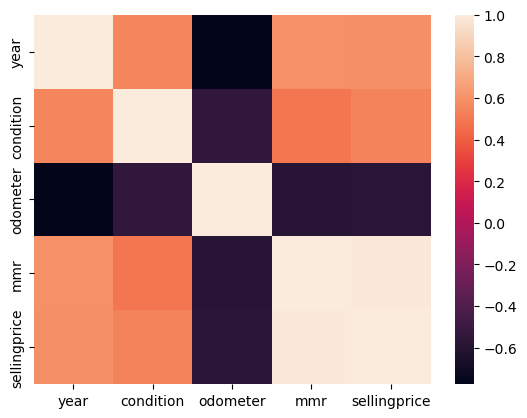

In [28]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix)

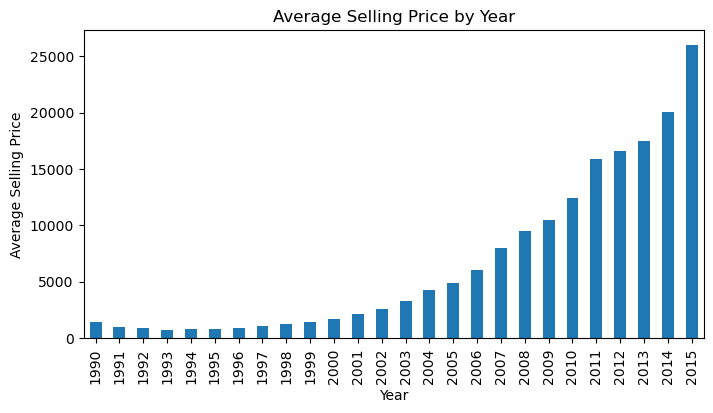

In [65]:
# Bar plot of average selling price by year
plt.figure(figsize=(8,4))
data.groupby('year')['sellingprice'].mean().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Average Selling Price')
plt.title('Average Selling Price by Year')
plt.show()

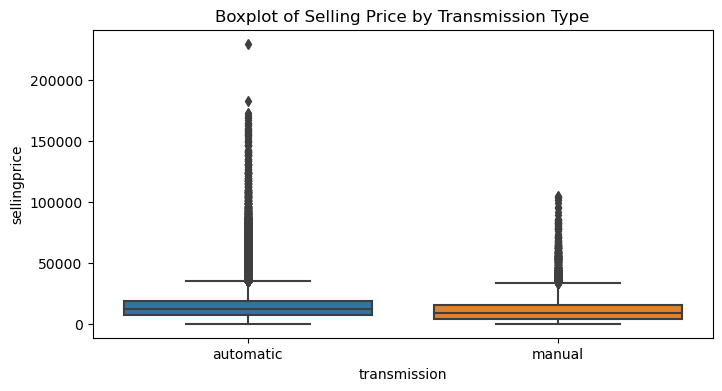

In [66]:
# Box plot of selling price by transmission
plt.figure(figsize=(8,4))
sns.boxplot(x='transmission', y='sellingprice', data=data)
plt.title('Boxplot of Selling Price by Transmission Type')
plt.show()

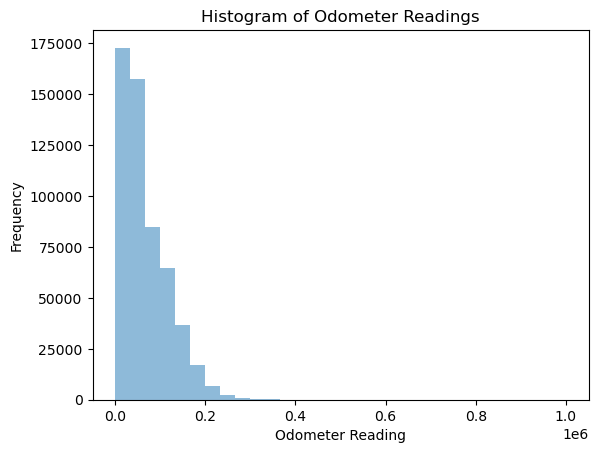

In [31]:
# Histogram of Odometer Readings
plt.hist(data['odometer'], bins=30, alpha=0.5)
plt.xlabel('Odometer Reading')
plt.ylabel('Frequency')
plt.title('Histogram of Odometer Readings')
plt.show()

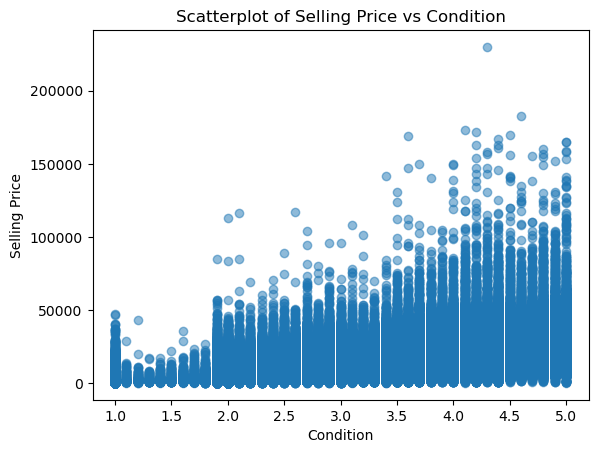

In [32]:
# Scatterplot of Selling Price vs Condition
plt.scatter(data['condition'], data['sellingprice'], alpha=0.5)
plt.xlabel('Condition')
plt.ylabel('Selling Price')
plt.title('Scatterplot of Selling Price vs Condition')
plt.show()

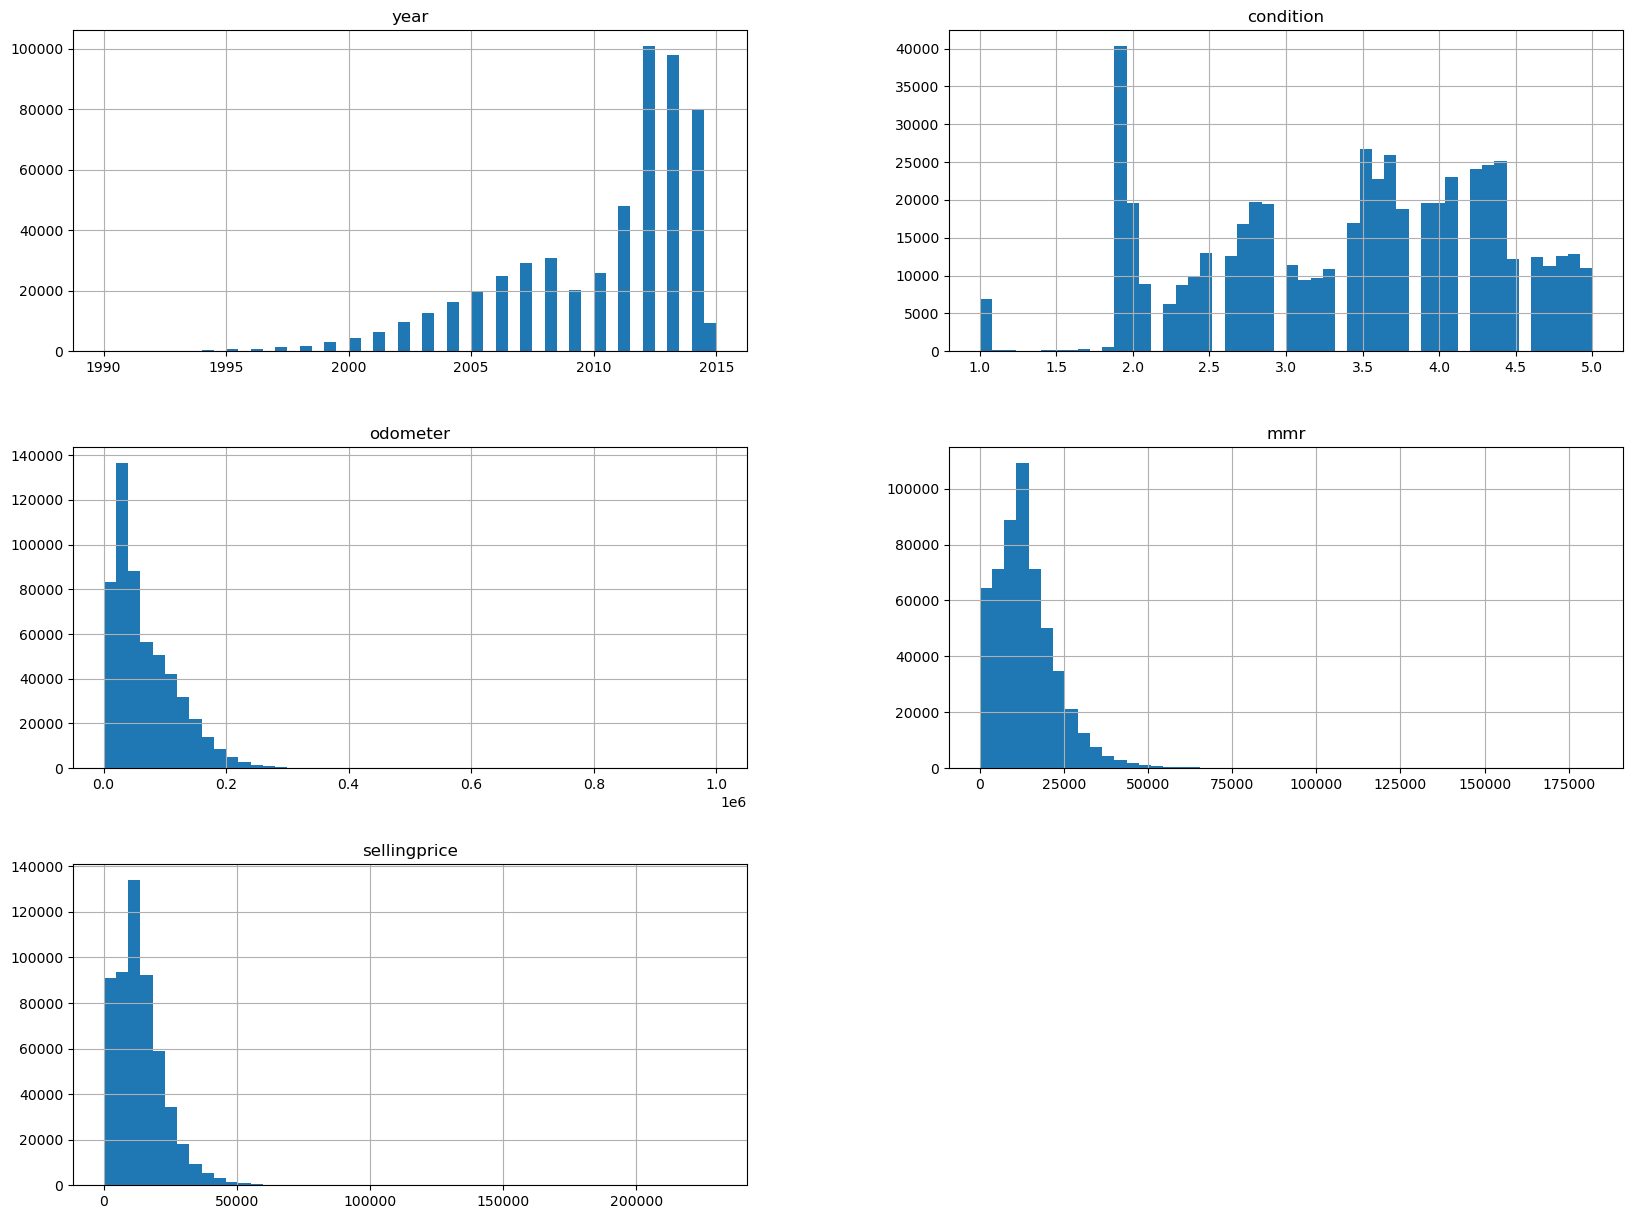

In [33]:
data.hist(bins=50, figsize=(20,15))
plt.show()

-----------

Data processing

In [34]:
# turning categorical columns to numerical depending on the type of categorical variable
ordinal_features = ['year']
categorical_features = ['transmission','state','make_model']
numerical_features = ['condition','odometer']

In [35]:
num_pipeline = Pipeline([
            ('scaler', StandardScaler())
])

In [36]:
ordinal_pipeline = Pipeline([
            ('ordinal',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [37]:
categorical_pipeline = Pipeline([
            ('categorical',OneHotEncoder(handle_unknown='ignore'))
])

In [38]:
preprocessor = ColumnTransformer(
            transformers = [('num',num_pipeline,numerical_features),
                ('ord',ordinal_pipeline, ordinal_features),
                ('categ',categorical_pipeline,categorical_features)
            ]
)

-----------

Data modeling

In [39]:
# Linear Regression Model

In [40]:
linear_reg_pipeline = Pipeline([
            ('preproc', preprocessor),
            ('reg', LinearRegression())
])

In [41]:
k = 5

indices = subset.index.values

# Initialize the cross-validation splitter
kf = KFold(n_splits=k, shuffle=True)

# Initialize arrays to store the test and train scores
cv_test_scores = np.zeros(k)
cv_train_scores = np.zeros(k)
cv_MSE = np.zeros(k)

# Perform cross-validation
for i, (train_index, test_index) in enumerate(kf.split(indices)):
    X_train, X_test = X.loc[list(train_index)], X.loc[list(test_index)]
    y_train, y_test = Y[train_index], Y[test_index]

    # Fit the pipeline on the training data
    linear_reg_pipeline.fit(X_train, y_train)

    # Evaluate using R^2 score on test data
    cv_test_scores[i] = linear_reg_pipeline.score(X_test, y_test)

    # Evaluate using R^2 score on train data
    cv_train_scores[i] = linear_reg_pipeline.score(X_train, y_train)

    # Evaluate using MSE
    predictions = linear_reg_pipeline.predict(X_test)
    cv_MSE[i] = mean_squared_error(y_test, predictions)

# Print the cross-validation scores
print("Cross-validation test scores:", cv_test_scores)
print("Mean CV test R^2 score:", cv_test_scores.mean())
print("Cross-validation train scores:", cv_train_scores)
print("Mean CV train R^2 score:", cv_train_scores.mean())
print("Mean CV MSE:", cv_MSE.mean())

Cross-validation test scores: [0.80775288 0.82026531 0.81023046 0.80639941 0.8229214 ]
Mean CV test R^2 score: 0.813513891757966
Cross-validation train scores: [0.82732146 0.8252911  0.82589449 0.83050484 0.82686002]
Mean CV train R^2 score: 0.8271743814918462
Mean CV MSE: 17522683.99178185


-----------

In [42]:
# Polynomial Regression with Degree 2
desired_degree = [2]
poly_reg_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('poly', PolynomialFeatures(desired_degree)),
    ('reg', LinearRegression())
])

In [43]:
cv_scores_mean = []
cv_train_scores_mean = []

for deg in desired_degree:
    poly_reg_pipeline.named_steps['poly'].degree = deg
    k = 5

    indices = subset.index.values

    # Initialize the cross-validation splitter
    kf = KFold(n_splits=k, shuffle=True)

    # Initialize an array to store the scores
    cv_test_scores = np.zeros(k)
    cv_train_scores = np.zeros(k)
    cv_MSE = np.zeros(k)

    # Perform cross-validation
    for i, (train_index, test_index) in enumerate(kf.split(indices)):
        X_train, X_test = X.loc[list(train_index)], X.loc[list(test_index)]
        y_train, y_test = Y[train_index], Y[test_index]

        # Fit the pipeline on the training data
        poly_reg_pipeline.fit(X_train, y_train)

        # Evaluate using R^2 Scoring on the test data
        cv_test_scores[i] = poly_reg_pipeline.score(X_test, y_test)

        # Evaluate using R^2 Scoring on the training data
        cv_train_scores[i] = poly_reg_pipeline.score(X_train, y_train)

        # Evaluate using MSE
        predictions = poly_reg_pipeline.predict(X_test)
        cv_MSE[i] = mean_squared_error(y_test, predictions)


    # Print the cross-validation scores
    print(f"Cross-validation test scores Polynomial Degree {deg}:", cv_test_scores)
    print("Mean CV test R^2 score:", cv_test_scores.mean())
    print(f"Cross-validation train scores Polynomial Degree {deg}:", cv_train_scores)
    print("Mean CV train R^2 score:", cv_train_scores.mean())
    print("Mean CV MSE:", cv_MSE.mean())
    cv_scores_mean.append(cv_test_scores.mean())
    cv_train_scores_mean.append(cv_train_scores.mean())

Cross-validation test scores Polynomial Degree 2: [0.87336313 0.90821349 0.90755686 0.91431875 0.90520735]
Mean CV test R^2 score: 0.9017319143834508
Cross-validation train scores Polynomial Degree 2: [0.93421824 0.92941467 0.93039654 0.92956963 0.93226543]
Mean CV train R^2 score: 0.93117290129245
Mean CV MSE: 9269615.68814611


-------

In [44]:
#Lasso Regression

In [45]:
lasso = Pipeline([
            ('preproc', preprocessor),
            ('lasso', Lasso(alpha = 0.001))
])

In [46]:
k = 5

indices = subset.index.values

# Initialize the cross-validation splitter
kf = KFold(n_splits=k, shuffle=True)

# Initialize an array to store the scores
cv_test_scores = np.zeros(k)
cv_train_scores = np.zeros(k)
cv_MSE = np.zeros(k)

for i, (train_index, test_index) in enumerate(kf.split(indices)):
    X_train, X_test = X.loc[list(train_index)], X.loc[list(test_index)]
    y_train, y_test = Y[train_index], Y[test_index]

    # Fit the pipeline on the training data
    lasso.fit(X_train, y_train)

    # Evaluate the pipeline on the test data
    cv_test_scores[i] = lasso.score(X_test, y_test)

    # Evaluate the pipeline on the training data
    cv_train_scores[i] = lasso.score(X_train, y_train)

     # Evaluate using MSE
    predictions = lasso.predict(X_test)
    cv_MSE[i] = mean_squared_error(y_test, predictions)

# Print the cross-validation scores
print("Cross-validation test scores Lasso Regression:", cv_test_scores)
print("Mean CV test R^2 score:", cv_test_scores.mean())
print("Cross-validation train scores Lasso Regression:", cv_train_scores)
print("Mean CV train R^2 score:", cv_train_scores.mean())
print("Mean CV MSE:", cv_MSE.mean())

Cross-validation test scores Lasso Regression: [0.8165692  0.8122635  0.82851745 0.78823466 0.81633291]
Mean CV test R^2 score: 0.8123835436098231
Cross-validation train scores Lasso Regression: [0.8242872  0.82541508 0.8251388  0.83406257 0.8269062 ]
Mean CV train R^2 score: 0.8271619709907352
Mean CV MSE: 17621479.788961075


------

In [47]:
# Model estimation

In [64]:
# What are the final parameter estimates?

# Extract the LinearRegression model from the pipeline
linear_reg_model = poly_reg_pipeline.named_steps['reg']

# Get the coefficients
coefficients = linear_reg_model.coef_
coefficients

array([[ 2.65354472e-09,  3.43916632e+02, -2.33617921e+02, ...,
        -1.28112232e+03,  0.00000000e+00,  2.97281966e+03]])

In [60]:
poly_reg_pipeline.fit(X, Y)
final_accuracy = poly_reg_pipeline.score(X, Y)
predicted_prices = poly_reg_pipeline.predict(X)

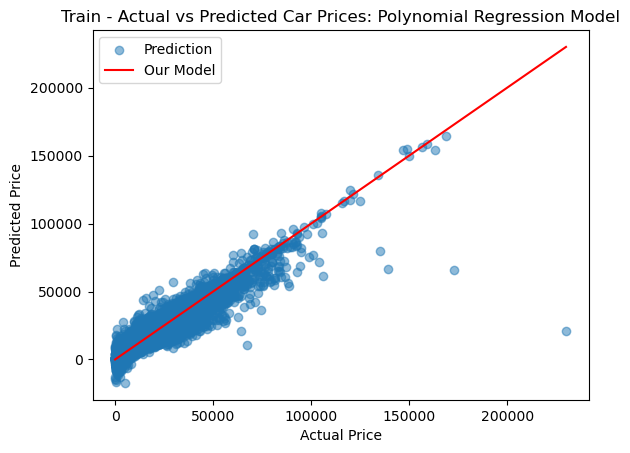

In [61]:
plt.scatter(Y, predicted_prices, alpha=0.5)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='red')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Train - Actual vs Predicted Car Prices: Polynomial Regression Model')
plt.legend(['Prediction', 'Our Model'])
plt.show()

In [50]:
poly_reg_pipeline.fit(X_test, y_test)
final_accuracy = poly_reg_pipeline.score(X_test, y_test)
predicted_prices = poly_reg_pipeline.predict(X_test)

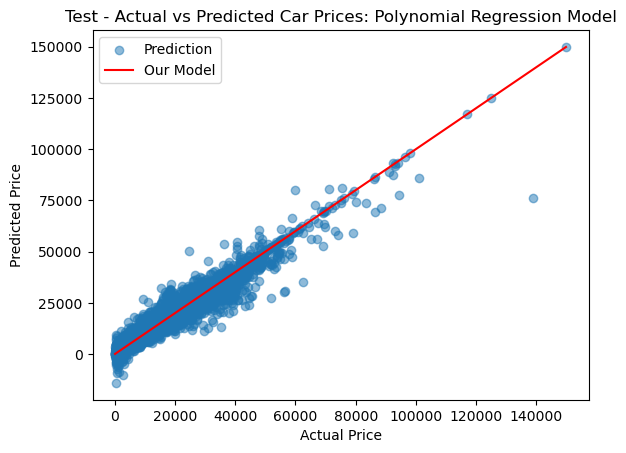

In [54]:
plt.scatter(y_test, predicted_prices, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Test - Actual vs Predicted Car Prices: Polynomial Regression Model')
plt.legend(['Prediction', 'Our Model'])
plt.show()